## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Make sure to change path if you put the zip elsewhere
#%unzip ../chest_xray.zip

UsageError: Line magic function `%unzip` not found.


## Create dataset from directory

In [4]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('../chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('../chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('../chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

2024-05-12 12:33:50.243865: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 12:33:50.396814: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 12:33:51.367090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 12:33:54.428069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


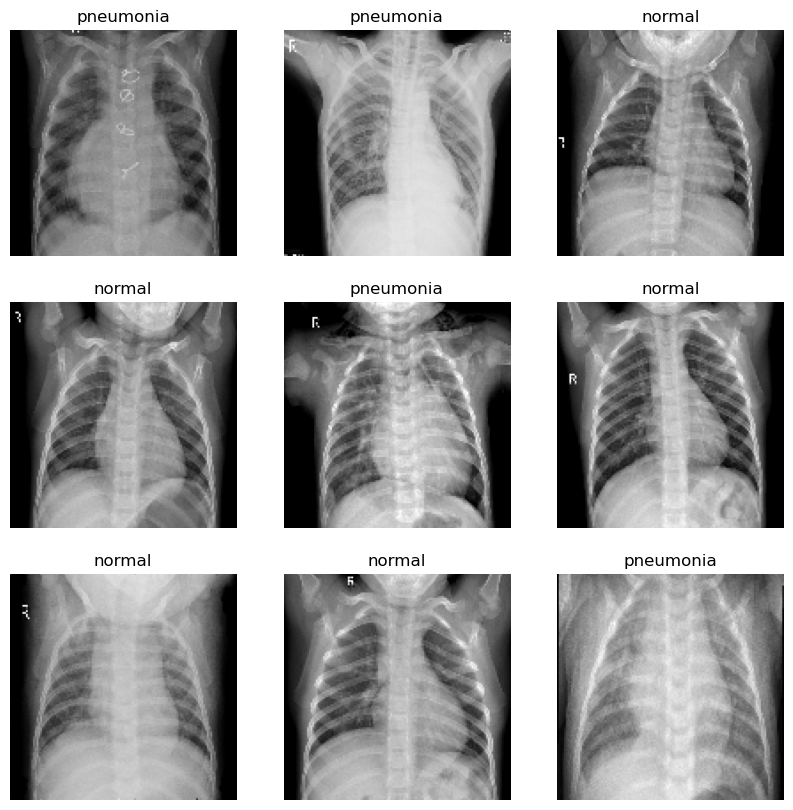

2024-05-12 12:33:59.757987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [6]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2024-05-12 12:34:18.819946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

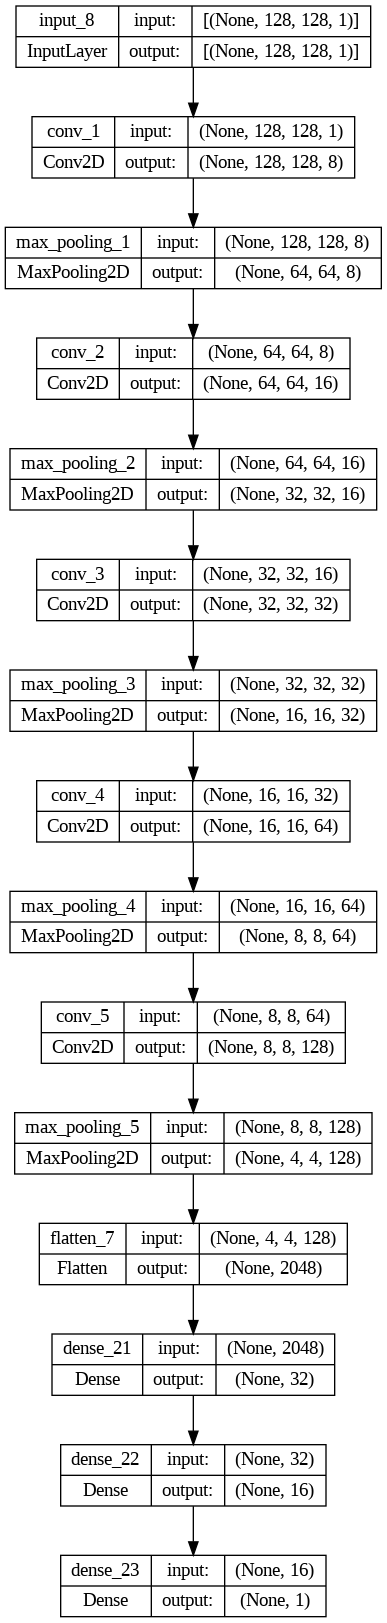

In [8]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses

)
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name='input_8')

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.



conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
max_pooling_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_1')(conv_1)

conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_2')(conv_2)

conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_pooling_2)    
max_pooling_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_3')(conv_3)

conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_pooling_3)    
max_pooling_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_4')(conv_4)

conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_pooling_4)    
max_pooling_5 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_5')(conv_5)

flatten_7 = Flatten(name='flatten_7')(max_pooling_5)


dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)


cnn_output = layers.Dense(1, activation='sigmoid')(dense_22)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [9]:
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_8 (InputLayer)            │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#%pip install pydot

In [11]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
#plot_model(cnn, show_shapes=True, show_layer_names=True)


In [12]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10


2024-05-12 12:34:25.820476: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-05-12 12:34:26.455614: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.
2024-05-12 12:34:26.455733: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.
2024-05-12 12:34:26.708501: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25952256 exceeds 10% of free system memory.
2024-05-12 12:34:26.886112: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


82/82 ━━━━━━━━━━━━━━━━━━━━ 52s 545ms/step - accuracy: 0.7630 - loss: 0.5520 - val_accuracy: 0.7500 - val_loss: 0.4905
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 520ms/step - accuracy: 0.9622 - loss: 0.1035 - val_accuracy: 0.8750 - val_loss: 0.2143
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 529ms/step - accuracy: 0.9632 - loss: 0.1000 - val_accuracy: 0.6875 - val_loss: 0.5423
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 523ms/step - accuracy: 0.9744 - loss: 0.0672 - val_accuracy: 1.0000 - val_loss: 0.1666
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 505ms/step - accuracy: 0.9805 - loss: 0.0551 - val_accuracy: 0.8750 - val_loss: 0.3360
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 509ms/step - accuracy: 0.9914 - loss: 0.0239 - val_accuracy: 0.9375 - val_loss: 0.1385
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 513ms/step - accuracy: 0.9946 - loss: 0.0166 - val_accuracy: 0.7500 - val_loss: 0.9001
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 509ms/step - accuracy: 0.9934 - loss: 0.0160 - val_accuracy: 0.750

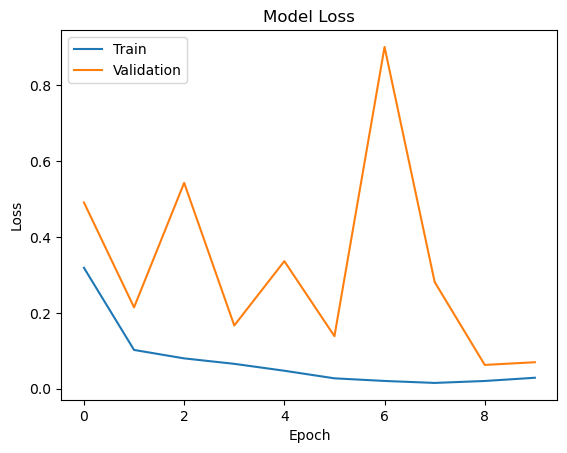

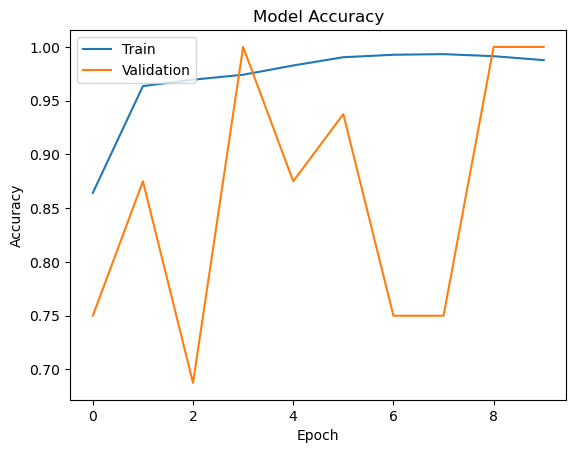

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

2024-05-12 12:44:57.892294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


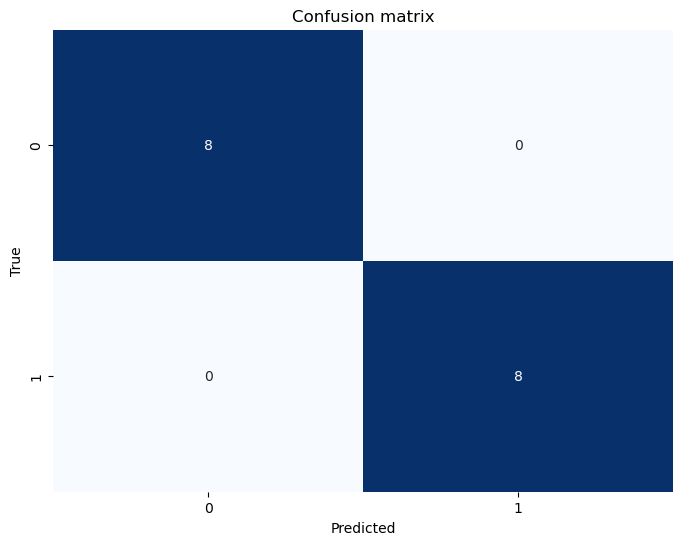

In [14]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set

val_prediction = cnn.predict(val_images).squeeze().round().astype(int)

cm = confusion_matrix(val_labels, val_prediction)

# Plot confusion matrix
pl.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
pl.title("Confusion matrix")
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()

2024-05-12 12:45:00.001778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


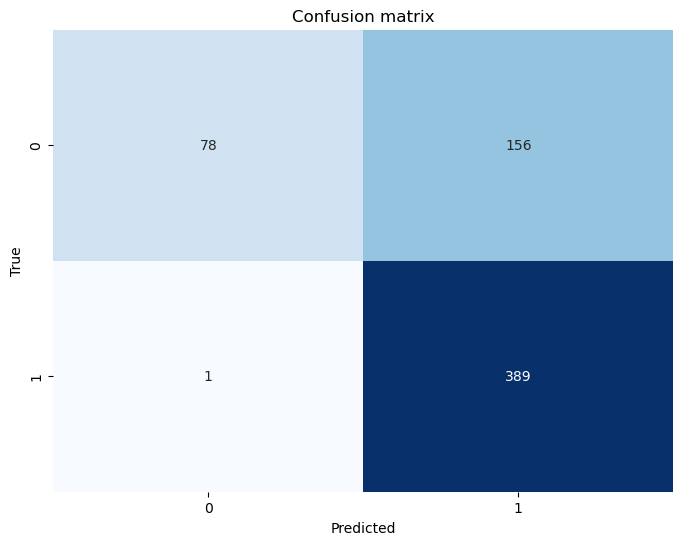

In [15]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images_test = []
val_labels_test = []

for img, label in test_ds:
  val_images_test.append(img)
  val_labels_test.append(label)

val_images_test = np.vstack(val_images_test)
val_labels_test = np.vstack(val_labels_test).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set

val_prediction_test = cnn.predict(val_images_test).squeeze().round().astype(int)

cm = confusion_matrix(val_labels_test, val_prediction_test)

# Plot confusion matrix
pl.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
pl.title("Confusion matrix")
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()

In [16]:
#F1 score and accuracy on the test set and validation set
from sklearn.metrics import f1_score, accuracy_score

val_f1 = f1_score(val_labels, val_prediction)
val_accuracy = accuracy_score(val_labels, val_prediction)

test_f1 = f1_score(val_labels_test, val_prediction_test)
test_accuracy = accuracy_score(val_labels_test, val_prediction_test)

print(f'Validation F1 score: {val_f1:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Test F1 score: {test_f1:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

Validation F1 score: 1.0000
Validation accuracy: 1.0000
Test F1 score: 0.8321
Test accuracy: 0.7484
